In [1]:
import numpy as np
import pandas as pd
import scipy
from utils import ClfEstimator
from utils import PCA
from oracles import BinaryLogistic
from optimization import GDClassifier, MinibatchGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

# Experiment 1

In [3]:
train = pd.read_csv("./Data/data_toxic/toxic_train.csv")
test = pd.read_csv("./Data/data_toxic/toxic_test.csv")

In [4]:
train = train.drop(columns=["index"])
test = test.drop(columns=["index"])

In [5]:
train.head(3)

,comment_text,is_toxic
0,Explanation\r\nWhy the edits made under my use...,False
1,D'aww! He matches this background colour I'm s...,False
2,"Hey man, I'm really not trying to edit war. It...",False


In [6]:
train.comment_text = train.comment_text.str.strip().str.lower()
test.comment_text = test.comment_text.str.strip().str.lower()

In [7]:
train.head(3)

,comment_text,is_toxic
0,explanation\r\nwhy the edits made under my use...,False
1,d'aww! he matches this background colour i'm s...,False
2,"hey man, i'm really not trying to edit war. it...",False


In [8]:
train.comment_text = train.comment_text.str.replace('[^a-zA-Z0-9]', ' ', regex=True)
test.comment_text = test.comment_text.str.replace('[^a-zA-Z0-9]', ' ', regex=True)

In [9]:
train.head(3)

,comment_text,is_toxic
0,explanation why the edits made under my usern...,False
1,d aww he matches this background colour i m s...,False
2,hey man i m really not trying to edit war it...,False


# Experiment 2

In [48]:
vectorizer = CountVectorizer(min_df=25, ngram_range=(1, 4))
X_train = vectorizer.fit_transform(train.comment_text)
X_test = vectorizer.transform(test.comment_text)

In [49]:
"fuck" in vectorizer.get_feature_names_out()

True

# Experiment 3

In [50]:
# OK. Check utils, test, tests

# Experiment 4

In [51]:
# MinibatchGDClassifier(loss_function="binary_logistic", batch_size=1, step_alpha=1,
#                       step_beta=0, tolerance=1e-5, max_iter=1000, random_seed=42, l2_coef=1)
#
# fit(self, X, y, X_val=None, y_val=None, w_0=None,
#     trace=False, train_subset_size=0.2, log_freq=0.1)

In [52]:
def unison_shuffled_copies(a, b):
    p = np.random.permutation(len(b))
    return a[p], b[p]

In [53]:
y_train = train.is_toxic.to_numpy() * 2 - 1
y_test = test.is_toxic.to_numpy() * 2 - 1

In [54]:
X_train, y_train = unison_shuffled_copies(X_train, y_train)

In [55]:
ones = scipy.sparse._csr.csr_matrix(np.ones((52061, 1)))
X_train = scipy.sparse.hstack((X_train, ones))
X_train.shape, type(X_train)

((52061, 25142), scipy.sparse._csr.csr_matrix)

In [56]:
ones = scipy.sparse._csr.csr_matrix(np.ones((20676, 1)))
X_test = scipy.sparse.hstack((X_test, ones))
X_test.shape, type(X_test)

((20676, 25142), scipy.sparse._csr.csr_matrix)

Нужно подвигать альфу. Построить heatmap-зависимость значения лосса и accuracy от альфы и итерации.

То же самое про бету.

Потом то же самое проделать, но зависимости строить не от итерации, а от времени работы.


alphas, GD

In [92]:
stats = list()
for alpha in np.logspace(start=-6, stop=1, num=8, base=10):
    print(alpha)
    clf = MinibatchGDClassifier(
                                loss_function="binary_logistic",
                                batch_size="full",
                                step_alpha=alpha, step_beta=0,
                                tolerance=1e-6, max_iter=100,
                                random_seed=42,
                                l2_coef=0.1
                               )
    history = clf.fit(X_train.toarray(), y_train, val_split=0.2,
                      trace=True, show_progress=False,
                      train_subset_size=0, log_freq=1)
    stats.append(
        (alpha, history)
    )

1e-06
Maximal iteration was reached
1e-05
Maximal iteration was reached
0.0001
Maximal iteration was reached
0.001
Maximal iteration was reached
0.01
Maximal iteration was reached
0.1
Maximal iteration was reached
1.0
Maximal iteration was reached
10.0
Maximal iteration was reached


In [96]:
alphas = list()
row = list()
for alpha, h in stats:
    alphas.append(alpha)
    row.append(h["val_accuracy"])

In [97]:
row = np.array(row)

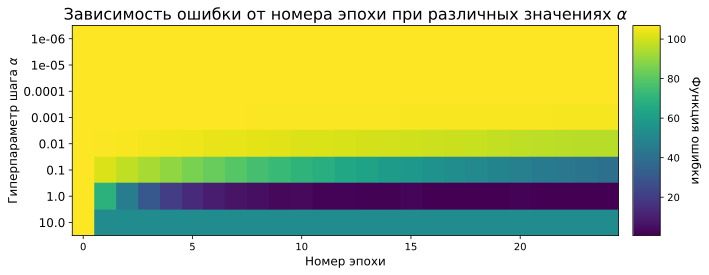

In [95]:
figure, ax = plt.subplots(1, figsize=(10, 4))
img = ax.imshow(row[:, :25], aspect="auto")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)

bar = ax.figure.colorbar(img, cax=cax)
bar.set_label('Функция ошибки', rotation=270, fontsize=12)
bar.ax.get_yaxis().labelpad = 15

# ax.set_xticks(np.arange(101), np.arange(101))
ax.set_title("Зависимость ошибки от номера эпохи при различных значениях $\\alpha$", fontsize=16)
ax.set_xlabel("Номер эпохи", fontsize=12)
ax.set_ylabel("Гиперпараметр шага $\\alpha$", fontsize=12)
ax.set_yticks(np.arange(8), alphas, fontsize=12)
plt.tight_layout()

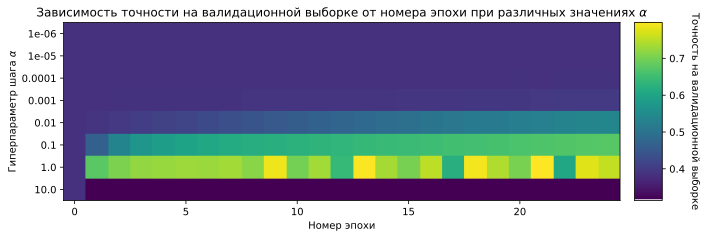

In [98]:
figure, ax = plt.subplots(1, figsize=(10, 4))
img = ax.imshow(row[:8, :25])

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)

bar = ax.figure.colorbar(img, cax=cax)
bar.set_label('Точность на валидационной выборке', rotation=270, fontsize=10)
bar.ax.get_yaxis().labelpad = 15

# ax.set_xticks(np.arange(101), np.arange(101))
ax.set_title("Зависимость точности на валидационной выборке от номера эпохи при различных значениях $\\alpha$")
ax.set_xlabel("Номер эпохи")
ax.set_ylabel("Гиперпараметр шага $\\alpha$")
ax.set_yticks(np.arange(8), alphas[:8], fontsize=10)
plt.tight_layout()

In [124]:
figure.savefig("../pyhometask/s6/pictures/GDbetas_val_accuracy.pdf")

In [99]:
stats = list()
for beta in np.logspace(start=-3, stop=3, num=10, base=10):
    print(beta)
    clf = MinibatchGDClassifier(
                                loss_function="binary_logistic",
                                batch_size="full",
                                step_alpha=1.0, step_beta=beta,
                                tolerance=1e-6, max_iter=100,
                                random_seed=42,
                                l2_coef=0.1
                               )
    history = clf.fit(X_train.toarray(), y_train, val_split=0.2,
                      trace=True, show_progress=False,
                      train_subset_size=0.2, log_freq=1)
    stats.append(
        (beta, history)
    )

0.001
Maximal iteration was reached
0.004641588833612777
Maximal iteration was reached
0.021544346900318832
Maximal iteration was reached
0.1
Maximal iteration was reached
0.46415888336127775
Maximal iteration was reached
2.154434690031882
Maximal iteration was reached
10.0
Tolerance threshold was hit
46.41588833612773
Tolerance threshold was hit
215.44346900318823
Tolerance threshold was hit
1000.0
Tolerance threshold was hit


In [100]:
clf = MinibatchGDClassifier(
                            loss_function="binary_logistic",
                            batch_size="full",
                            step_alpha=1.0, step_beta=0,
                            tolerance=1e-6, max_iter=100,
                            random_seed=42,
                            l2_coef=0.1
                           )
history = clf.fit(X_train.toarray(), y_train, val_split=0.2,
                  trace=True, show_progress=False,
                  train_subset_size=0.2, log_freq=1)
stats = [(0.0, history)] + stats

Maximal iteration was reached


Тут надо сказать про то, что градиент просто умирал из-за мнoжителя и функция не менялась => останов

In [137]:
betas = list()
row = list()
for beta, h in stats:
    betas.append(beta)
    row.append(h["val_accuracy"])
row = np.array(row)

In [138]:
for i in range(len(betas)):
    betas[i] = round(betas[i], 2)

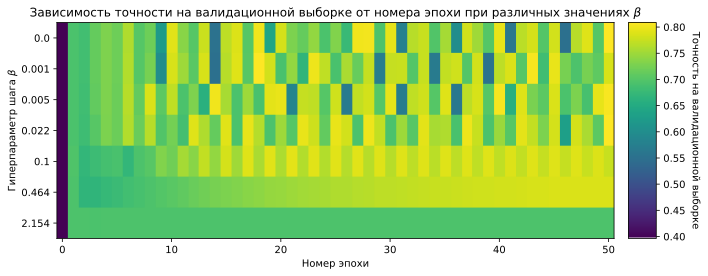

In [123]:
figure, ax = plt.subplots(1, figsize=(10, 4))
img = ax.imshow(row[:, :100], aspect="auto")

divider = make_axes_locatable(ax)
cax = cax = divider.append_axes('right', size='5%', pad=0.2)

bar = ax.figure.colorbar(img, cax=cax)
bar.set_label('Точность на валидационной выборке', rotation=270, fontsize=10)
bar.ax.get_yaxis().labelpad = 15

ax.set_title("Зависимость точности на валидационной выборке от номера эпохи при различных значениях $\\beta$")
ax.set_xlabel("Номер эпохи")
ax.set_ylabel("Гиперпараметр шага $\\beta$")
ax.set_yticks(np.arange(7), betas[:7], fontsize=10)
plt.tight_layout()

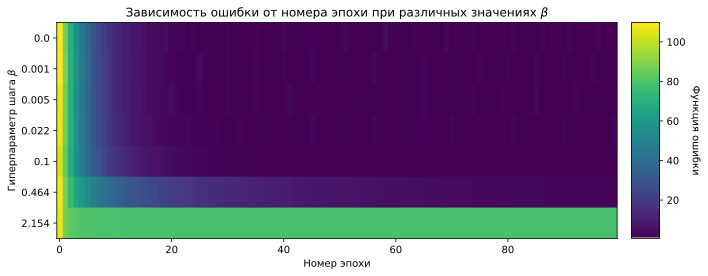

In [235]:
figure, ax = plt.subplots(1, figsize=(10, 4))
img = ax.imshow(row[:, :100], aspect="auto")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)

bar = ax.figure.colorbar(img, cax=cax)
bar.set_label('Функция ошибки', rotation=270, fontsize=10)
bar.ax.get_yaxis().labelpad = 15

# ax.set_xticks(np.arange(101), np.arange(101))
ax.set_title("Зависимость ошибки от номера эпохи при различных значениях $\\beta$")
ax.set_xlabel("Номер эпохи")
ax.set_ylabel("Гиперпараметр шага $\\beta$")
ax.set_yticks(np.arange(7), betas[:7], fontsize=10)
plt.tight_layout()

Более точно подберём бету.

In [136]:
stats = list()
for beta in np.linspace(0.05, 0.85, 9):
    print(beta)
    clf = MinibatchGDClassifier(
                                loss_function="binary_logistic",
                                batch_size="full",
                                step_alpha=1.0, step_beta=beta,
                                tolerance=1e-6, max_iter=100,
                                random_seed=42,
                                l2_coef=0.1
                               )
    history = clf.fit(X_train.toarray(), y_train, val_split=0.2,
                      trace=True, show_progress=False,
                      train_subset_size=0.2, log_freq=1)
    stats.append(
        (beta, history)
    )

0.05
Maximal iteration was reached
0.15
Maximal iteration was reached
0.25
Maximal iteration was reached
0.35
Maximal iteration was reached
0.44999999999999996
Maximal iteration was reached
0.5499999999999999
Maximal iteration was reached
0.65
Maximal iteration was reached
0.75
Maximal iteration was reached
0.85
Maximal iteration was reached


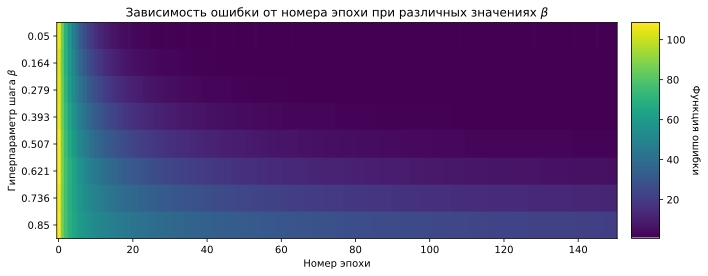

In [52]:
figure, ax = plt.subplots(1, figsize=(10, 4))
img = ax.imshow(row[:, :], aspect="auto")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)

bar = ax.figure.colorbar(img, cax=cax)
bar.set_label('Функция ошибки', rotation=270, fontsize=10)
bar.ax.get_yaxis().labelpad = 15

# ax.set_xticks(np.arange(101), np.arange(101))
ax.set_title("Зависимость ошибки от номера эпохи при различных значениях $\\beta$")
ax.set_xlabel("Номер эпохи")
ax.set_ylabel("Гиперпараметр шага $\\beta$")
ax.set_yticks(np.arange(8), betas, fontsize=10)
plt.tight_layout()

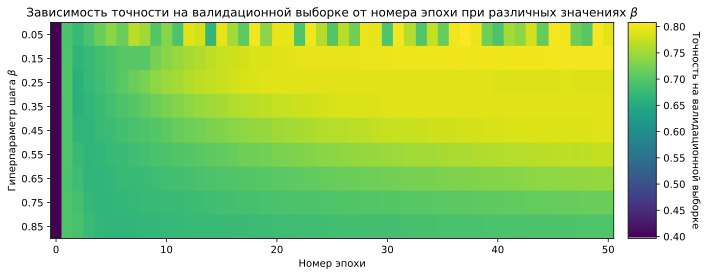

In [139]:
figure, ax = plt.subplots(1, figsize=(10, 4))
img = ax.imshow(row[:, :], aspect="auto")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)

bar = ax.figure.colorbar(img, cax=cax)
bar.set_label('Точность на валидационной выборке', rotation=270, fontsize=10)
bar.ax.get_yaxis().labelpad = 15

# ax.set_xticks(range(50), range(50, 100))
ax.set_title("Зависимость точности на валидационной выборке от номера эпохи при различных значениях $\\beta$")
ax.set_xlabel("Номер эпохи")
ax.set_ylabel("Гиперпараметр шага $\\beta$")
ax.set_yticks(np.arange(9), betas, fontsize=10)
plt.tight_layout()

In [145]:
np.random.randn(4)

array([ 1.77154772, -1.30267803,  1.87871335, -1.93556671])

In [169]:
stats = list()
n = X_train.shape[1]

w1 = np.zeros(n)
w2 = np.ones(n)
w3 = None
w4 = (np.random.random(n) - 0.5) * 10
w5 = np.random.randn(n)

for i, w0 in enumerate([w1, w2, w3, w4, w5]):
    print(i+1)
    clf = MinibatchGDClassifier(
                                loss_function="binary_logistic",
                                batch_size="full",
                                step_alpha=1.0, step_beta=0.3,
                                tolerance=1e-6, max_iter=50,
                                random_seed=42,
                                l2_coef=0.1
                               )
    history = clf.fit(X_train.toarray(), y_train, val_split=0.2,
                      trace=True, show_progress=False,
                      train_subset_size=0, log_freq=1, w_0=w0)

    stats.append(history)

1
Maximal iteration was reached
2
Maximal iteration was reached
3
Maximal iteration was reached
4
Maximal iteration was reached
5
Maximal iteration was reached


In [201]:
row = list()
for h in stats:
    row.append(h["val_accuracy"])
row = np.array(row)

In [171]:
inits = [
    "Нулевая",
    "Единичная",
    "Равномерная на [0, 1]",
    "Равномерная на [-5, 5]",
    "Нормальная"
]

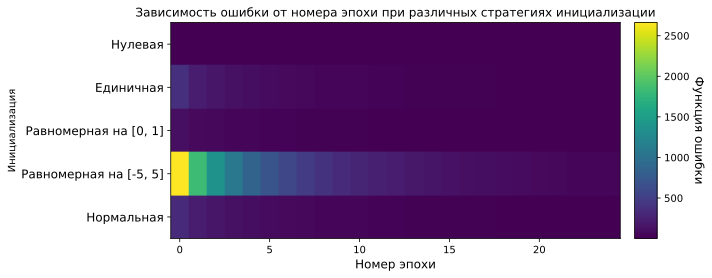

In [188]:
figure, ax = plt.subplots(1, figsize=(10, 4))
img = ax.imshow(row[:, :25], aspect="auto")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)

bar = ax.figure.colorbar(img, cax=cax)
bar.set_label('Функция ошибки', rotation=270, fontsize=12)
bar.ax.get_yaxis().labelpad = 15

ax.set_title("Зависимость ошибки от номера эпохи при различных стратегиях инициализации")
ax.set_xlabel("Номер эпохи", fontsize=12)
ax.set_ylabel("Инициализация")
ax.set_yticks(np.arange(5), inits, fontsize=12)
plt.tight_layout()

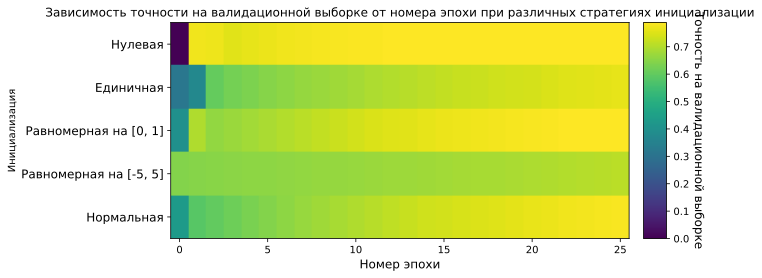

In [202]:
figure, ax = plt.subplots(1, figsize=(10, 4))
img = ax.imshow(row[:, :100], aspect="auto")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)

bar = ax.figure.colorbar(img, cax=cax)
bar.set_label('Точность на валидационной выборке', rotation=270, fontsize=12)
bar.ax.get_yaxis().labelpad = 15

ax.set_title("Зависимость точности на валидационной выборке от номера эпохи при различных стратегиях инициализации")
ax.set_xlabel("Номер эпохи", fontsize=12)
ax.set_ylabel("Инициализация")
ax.set_yticks(np.arange(5), inits, fontsize=12)
plt.tight_layout()

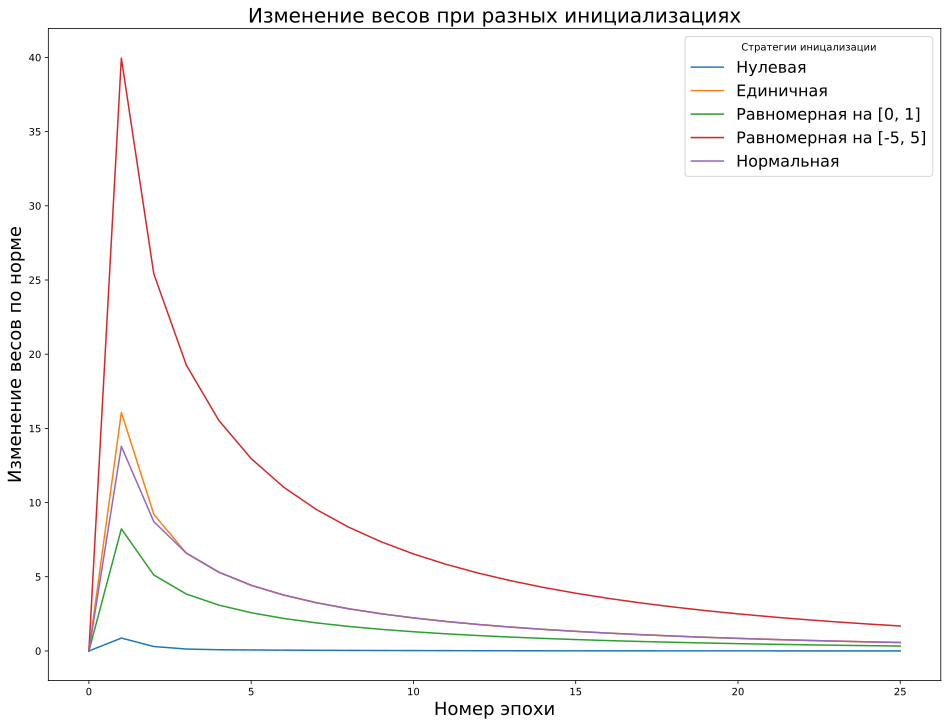

In [199]:
figure, ax = plt.subplots(1, figsize=(16, 12))
for i, f in enumerate(row):
    f = np.array(f)
    ax.plot(range(len(f)), f, label=inits[i])
ax.set_title("Изменение весов при разных инициализациях", fontsize=20)
ax.set_xlabel("Номер эпохи", fontsize=18)
ax.set_ylabel("Изменение весов по норме", fontsize=18)
ax.legend(title="Стратегии иницализации", fontsize=16)

In [200]:
figure.savefig("../pyhometask/s6/pictures/GDw0_w_diff.pdf")

In [28]:
# Смотри выше. Получится куча таких историй. Выбери
# из них функции и train/val accuracy. Построй кучу (3) графиков  ними связанных.
# Спектрограмма альфа по высоте, итерация по длине, параметр - глубина.
#
# Посмотреть разные начальные приближения => изменится скорость достижения одного и того
# же accuracy. Нарисовать график accuracy от эпохи (несколько линий для разных w)

In [ ]:
# далее смотрим на батчи разных размеров, делаем выводы о скорости сходимости
# Для этого везде используем одну инициализацию, смотрим за сколько итераций (и времени)
# достигается какой-то уровень accuracy

In [167]:
from time import time

1668358138.4609685

In [45]:
stats = list()
for bs in [1, 2, 50, 250, 2500, 10000, 41649]:
    print(bs)
    clf = MinibatchGDClassifier(
                                loss_function="binary_logistic",
                                batch_size=bs,
                                step_alpha=1.0, step_beta=0.3,
                                tolerance=1e-6, max_iter=500 if bs <= 2500 else 75,
                                random_seed=42,
                                l2_coef=0.1
                               )
    history = clf.fit(X_train.toarray(), y_train, val_split=0.2,
                      trace=True, show_progress=False,
                      train_subset_size=0.2, log_freq=(bs / 41649))
    stats.append(
        (bs, history)
    )

1
Maximal iteration was reached
2
Maximal iteration was reached
50
Maximal iteration was reached
250
Maximal iteration was reached
2500
Tolerance threshold was hit
10000
Maximal iteration was reached
41649
Maximal iteration was reached


In [69]:
bss = list()
row = list()
for bs, h in stats:
    bss.append(bs)
    row.append(
        [h["time"], h["val_accuracy"]]
    )

In [70]:
for i in range(len(row)):
    row[i][0] = np.cumsum(row[i][0])

In [84]:
figure.savefig("../pyhometask/s6/pictures/GDbatch_val_accuracy.pdf")

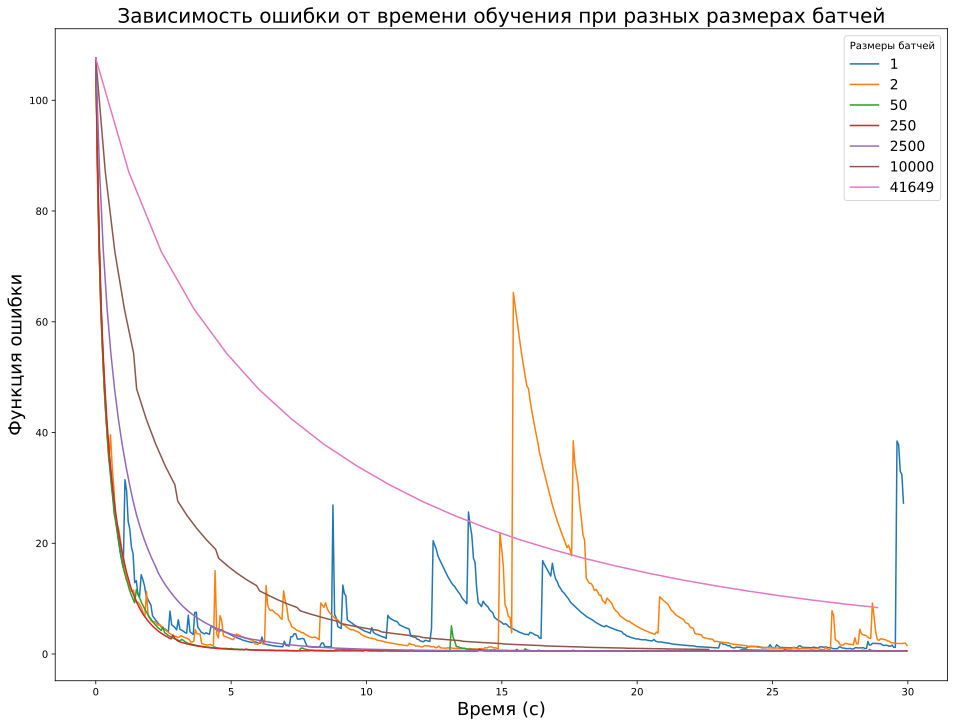

In [68]:
figure, ax = plt.subplots(1, figsize=(16, 12))
for i, (t, f) in enumerate(row):
    cond = t < 30
    t = t[cond]
    f = np.array(f)
    f = f[cond]
    ax.plot(t, f, label=bss[i])
ax.set_title("Зависимость ошибки от времени обучения при разных размерах батчей", fontsize=20)
ax.set_xlabel("Время (с)", fontsize=18)
ax.set_ylabel("Функция ошибки", fontsize=18)
ax.legend(title="Размеры батчей", fontsize=14)

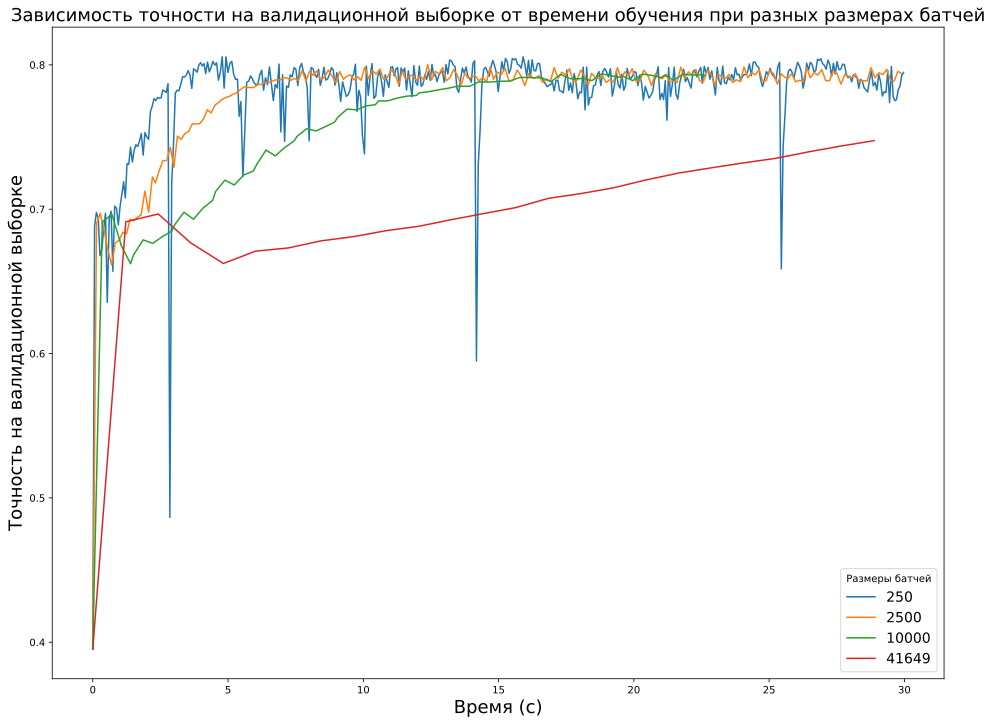

In [83]:
figure, ax = plt.subplots(1, figsize=(16, 12))
lst = list()
for i, (t, f) in enumerate(row[3:]):
    cond = t < 30
    t = t[cond]
    f = np.array(f)
    f = f[cond]
    ax.plot(t, f, label=bss[i+3])
ax.set_title("Зависимость точности на валидационной выборке от времени обучения при разных размерах батчей", fontsize=18)
ax.set_xlabel("Время (с)", fontsize=18)
ax.set_ylabel("Точность на валидационной выборке", fontsize=18)
ax.legend(title="Размеры батчей", fontsize=14)

In [203]:
stats = list()
for alpha in np.logspace(start=-6, stop=1, num=8, base=10):
    print(alpha)
    clf = MinibatchGDClassifier(
                                loss_function="binary_logistic",
                                batch_size=2500,
                                step_alpha=alpha, step_beta=0,
                                tolerance=1e-6, max_iter=100,
                                random_seed=42,
                                l2_coef=0.1
                               )
    history = clf.fit(X_train.toarray(), y_train, val_split=0.2,
                      trace=True, show_progress=False,
                      train_subset_size=0, log_freq=1)
    stats.append(
        (alpha, history)
    )

1e-06
Maximal iteration was reached
1e-05
Maximal iteration was reached
0.0001
Maximal iteration was reached
0.001
Maximal iteration was reached
0.01
Maximal iteration was reached
0.1
Maximal iteration was reached
1.0
Maximal iteration was reached
10.0
Maximal iteration was reached


In [204]:
alphas = list()
row = list()
for alpha, h in stats:
    alphas.append(alpha)
    row.append(h["func"])

In [209]:
stats[0][1]["epoch_num"]

[0.0, 1.02, 2.04, 3.06, 4.08, 5.1]

In [205]:
row = np.array(row)

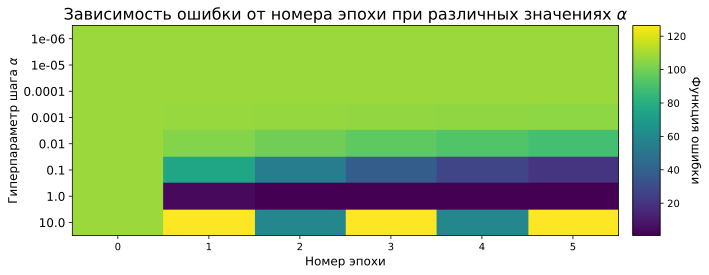

In [207]:
figure, ax = plt.subplots(1, figsize=(10, 4))
img = ax.imshow(row[:, :50], aspect="auto")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)

bar = ax.figure.colorbar(img, cax=cax)
bar.set_label('Функция ошибки', rotation=270, fontsize=12)
bar.ax.get_yaxis().labelpad = 15

# ax.set_xticks(np.arange(101), np.arange(101))
ax.set_title("Зависимость ошибки от номера эпохи при различных значениях $\\alpha$", fontsize=16)
ax.set_xlabel("Номер эпохи", fontsize=12)
ax.set_ylabel("Гиперпараметр шага $\\alpha$", fontsize=12)
ax.set_yticks(np.arange(8), alphas, fontsize=12)
plt.tight_layout()

In [210]:
figure.savefig("../pyhometask/s6/pictures/GDbatch2500_func.pdf")

# Повышение точности

In [227]:
clf = MinibatchGDClassifier(
                            loss_function="binary_logistic",
                            batch_size=2500,
                            step_alpha=1.0, step_beta=0.3,
                            tolerance=1e-6, max_iter=100,
                            random_seed=42,
                            l2_coef=0.1
                           )
history = clf.fit(X_train.toarray(), y_train, val_split=0.2,
                  trace=True, show_progress=False,
                  train_subset_size=0, log_freq=1)

Maximal iteration was reached


In [243]:
X_train.shape

(52061, 6239)

In [242]:
clf.estimator.metric["accuracy"](clf.predict(X_test.toarray()), y_test)

0.7629135229251306

In [251]:
import nltk
from nltk import WordNetLemmatizer
from nltk.corpus import wordnet

In [252]:
train.head(5)

,comment_text,is_toxic
0,explanation why the edits made under my usern...,False
1,d aww he matches this background colour i m s...,False
2,hey man i m really not trying to edit war it...,False
3,more i can t make any real suggestions on ...,False
4,you sir are my hero any chance you remember...,False


In [271]:
#OK
train.head(5)

,comment_text,is_toxic
0,explanation why the edits make under my userna...,False
1,d aww he match this background colour i m seem...,False
2,hey man i m really not try to edit war it s ju...,False
3,more i can t make any real suggestion on impro...,False
4,you sir be my hero any chance you remember wha...,False


In [303]:
#OK
train.head(5)

,comment_text,is_toxic
0,explanation edits make username hardcore metal...,False
1,aww match background colour seemingly stick th...,False
2,hey man really try edit war guy constantly rem...,False
3,make real suggestion improvement wonder sectio...,False
4,sir hero chance remember page,False


In [253]:
def simple_lemmatizer(sentence):
    lemmatizer = WordNetLemmatizer()
    tokenized_sent = sentence.split()
    pos_taged = [
        (word, get_wordnet_pos(tag))
        for word, tag in nltk.pos_tag(tokenized_sent)
    ]
    return " ".join([
        lemmatizer.lemmatize(word, tag)
        for word, tag in pos_taged
    ])

In [254]:
def get_wordnet_pos(treebank_tag):
    my_switch = {
        'J': wordnet.ADJ, 'V': wordnet.VERB,
        'N': wordnet.NOUN, 'R': wordnet.ADV
    }
    for key, item in my_switch.items():
        if treebank_tag.startswith(key):
            return item
    return wordnet.NOUN

In [298]:
def simple_deleter(sentence):
    sentence = sentence.split()
    new = [elem for elem in sentence if elem not in stopWords]
    return " ".join(new)

In [255]:
simple_lemmatizer("I wrote it, you write that")

'I write it, you write that'

In [379]:
for i in range(len(train.comment_text)):
    if not (i % 5000):
        print(i)
    train.comment_text[i] = simple_lemmatizer(train.comment_text[i])

0


<ipython-input-379-f5f9de6354d5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.comment_text[i] = simple_lemmatizer(train.comment_text[i])


5000
10000
15000
20000
25000
30000
35000
40000
45000
50000


In [278]:
X_train.shape

(52061, 5167)

In [283]:
from time import time

In [45]:
clf = MinibatchGDClassifier(
                            loss_function="binary_logistic",
                            batch_size=2500,
                            step_alpha=1.0, step_beta=0.3,
                            tolerance=1e-6, max_iter=100,
                            random_seed=42,
                            l2_coef=0.1
                           )

history = clf.fit(X_train.toarray(), y_train, val_split=0.2,
                  trace=True, show_progress=False,
                  train_subset_size=0, log_freq=2500/52061)

Maximal iteration was reached


In [46]:
sum(history["time"])

40.6467022895813

In [57]:
# 4_grams
clf.estimator.metric["accuracy"](clf.predict(X_test.toarray()), y_test)

0.7613755811129934

In [47]:
# tri_grams
clf.estimator.metric["accuracy"](clf.predict(X_test.toarray()), y_test)

0.7654768814083962

In [35]:
# bi_grams
clf.estimator.metric["accuracy"](clf.predict(X_test.toarray()), y_test)

0.7634939059779454

In [520]:
clf.estimator.metric["accuracy"](clf.predict(X_test.toarray()), y_test)

0.7594312246082414

In [463]:
clf.estimator.metric["accuracy"](clf.predict(X_test.toarray()), y_test)

0.7352002321532212

In [452]:
clf.estimator.metric["accuracy"](clf.predict(X_test.toarray()), y_test)

0.736602824530857

In [291]:
clf.estimator.metric["accuracy"](clf.predict(X_test.toarray()), y_test)

0.7567227703617722

In [439]:
np.count_nonzero(clf.predict(X_test.toarray()) == 1)

0

In [297]:
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

In [389]:
for i in range(len(train.comment_text)):
    if not (i % 5000):
        print(i)
    train.comment_text[i] = simple_deleter(train.comment_text[i])

0
5000

<ipython-input-389-8ce2c25ffdd4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.comment_text[i] = simple_deleter(train.comment_text[i])



10000
15000
20000
25000
30000
35000
40000
45000
50000


In [505]:
stats = list()
for reg in np.logspace(start=-3, stop=1, num=5, base=10):
    print(reg)
    clf = MinibatchGDClassifier(
                                loss_function="binary_logistic",
                                batch_size=2500,
                                step_alpha=1.0, step_beta=0.3,
                                tolerance=1e-6, max_iter=100,
                                random_seed=42,
                                l2_coef=reg
                               )
    history = clf.fit(X_train.toarray(), y_train, val_split=0.2,
                      trace=False, show_progress=False,
                      train_subset_size=0, log_freq=1)
    print(clf.estimator.metric["accuracy"](clf.predict(X_test.toarray()), y_test))

0.001
Maximal iteration was reached
0.7178854710775778
0.01
Maximal iteration was reached
0.72929967111627
0.1
Maximal iteration was reached
0.7594312246082414
1.0
Maximal iteration was reached
0.742890307603018
10.0
Maximal iteration was reached
0.3430547494679822


In [499]:
regs = list()
row = list()
for reg, h in stats[:-1]:
    regs.append(reg)
    row.append(h["func"])

In [ ]:
pca = PCA()
pca.fit_transform(X_train.toarray(), target_dim=5000)

In [500]:
regs

[0.001, 0.01, 0.1, 1.0]

In [501]:
row = np.array(row)

In [524]:
vectorizer.get_feature_names_out()[X_test[8, :-1].astype(bool).toarray().reshape(-1)]

array(['also', 'arabs', 'are', 'burn', 'but', 'europe', 'genocide',
       'hell', 'in', 'iraq', 'may', 'no'], dtype=object)

In [532]:
vectorizer.get_feature_names_out()[X_test[24, :-1].astype(bool).toarray().reshape(-1)]

array(['as', 'dick', 'gay', 'he', 'hell', 'his', 'is', 'much', 'so',
       'sucks'], dtype=object)

In [533]:
vectorizer.get_feature_names_out()[X_test[38, :-1].astype(bool).toarray().reshape(-1)]

array(['about', 'again', 'dare', 'don', 'how', 'page', 'that', 'the',
       'vandalize', 'you'], dtype=object)

In [534]:
vectorizer.get_feature_names_out()[X_test[20673, :-1].astype(bool).toarray().reshape(-1)]

array(['anyone', 'being', 'belief', 'clever', 'does', 'else', 'fourth',
       'he', 'indeed', 'is', 'made', 'more', 'my', 'of', 'out',
       'possibly', 'proof', 'share', 'shows', 'small', 'stupidity',
       'than', 'that', 'the', 'very'], dtype=object)

In [521]:
y_pred = clf.predict(X_test.toarray())

In [523]:
np.where(y_pred.reshape(-1) != y_test.reshape(-1))

(array([    8,    24,    38, ..., 20673, 20674, 20675]),)

In [525]:
y_pred[8]

array([-1.])

In [526]:
y_pred[24]

array([-1.])

In [527]:
y_pred[38]

array([-1.])

In [528]:
y_pred[20673]

array([-1.])

In [530]:
y_pred[20674]

array([-1.])

In [531]:
y_pred[20675]

array([-1.])

In [538]:
data @ np.array([[-0.44], [-0.89]])

array([[-0.555],
       [ 0.555]])

In [539]:
data

array([[ 0.25,  0.5 ],
       [-0.25, -0.5 ]])